In [2]:
import openai
import re
import time

import numpy as np
import random

from tqdm import tqdm
from datasets import load_dataset

In [3]:
import string
from collections import Counter

def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)
    
    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    
    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall

In [4]:
import random
import openai
import re

def get_prompts(n=4):
    with open('prompts.txt', 'r') as file:
        content = file.read().split('\n\n')
    
    prompts = [prompt.replace('\n', ' ').strip() for prompt in content if prompt.strip()]
    
    # Maybe throw error if it's larger idrk
    n = min(n, len(prompts))
    
    return random.sample(prompts, n)

def construct_multi_shot(num_shot = 4):
    instruction = 'Answer the final question following the exact format of the given examples. Do not output anything else.\n\nExample problems:\n\n'
    example_demonstrations = get_prompts(num_shot)
    prompt = instruction
    for line in example_demonstrations:
        s = line
        prompt += s + '\n'
    prompt += '\n'
    prompt += f"Q:"
    return prompt

def construct_0_shot():
  instruction = 'Answer the question in the following format: So the answer is: <final answer>. If the answer is yes, no, or no answer, only return yes, no, or no answer. Think step by step.'
  return instruction

# test


def trim_non_alphabetical(s):
    return re.sub(r'^[^a-zA-Z]+|[^a-zA-Z]+$', '', s)

def extract_answer(text):
    match = re.search(r"is:(.*)", text)
    if match:
        return trim_non_alphabetical(match.group(1).strip())
    else:
        return None



In [5]:
dataset = load_dataset("hotpot_qa", "fullwiki", trust_remote_code=True)

In [6]:
test_data = dataset['validation']

In [7]:
def get_question(prompt, index):
    question = test_data['question'][index]
    prompt_q = prompt + question + '\n'
    return prompt_q

In [8]:
def query(prompt):
    client = openai.OpenAI()
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Follow the given instructions and answer the question."},
            {
                "role": "user",
                "content": prompt
            }
        ]
    )

    return completion.choices[0].message.content

In [9]:
prompt =get_question(construct_0_shot(), 0)
result = query(prompt)

In [10]:
result, test_data['answer'][0]

('To determine if Scott Derrickson and Ed Wood were of the same nationality, we first need to identify their nationalities. \n\nScott Derrickson is an American film director and screenwriter, known for works such as "Sinister" and "Doctor Strange." \n\nEd Wood, on the other hand, was also an American filmmaker, famously known for his cult films. \n\nSince both individuals are from the United States, they share the same nationality.\n\nSo the answer is: yes.',
 'yes')

In [12]:
def extract_answer(text):
    matches = re.findall(r"is:(.*)", text)
    if matches:
        return matches[-1]
    else:
        return text.split()[-1]

In [13]:
all_indexes = list(range(len(test_data)))

random_indexes = random.sample(all_indexes, 300)

In [14]:
from tqdm import tqdm

matched = []
unmatched = []
total_items = len(random_indexes)
total_f1 = 0
total_precision = 0
total_recall = 0

for i in tqdm(random_indexes, total=total_items, desc="Processing"):
    prompt = get_question(construct_multi_shot(), i)
    result = query(prompt)
    extracted_answer = extract_answer(result)
    expected_answer = test_data['answer'][i]
    
    f1, precision, recall = f1_score(extracted_answer, expected_answer)
    total_f1 += f1
    total_precision += precision
    total_recall += recall
    
    item_data = {
        'index': i,
        'prompt': prompt,
        'result': result,
        'extracted_answer': extracted_answer,
        'expected_answer': expected_answer,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
    
    if f1 == 1.0:  # Perfect match
        matched.append(item_data)
    else:
        unmatched.append(item_data)

# Final statistics
avg_f1 = total_f1 / total_items
avg_precision = total_precision / total_items
avg_recall = total_recall / total_items

print(f"\nMatched (perfect F1 score): {len(matched)}")
print(f"Unmatched: {len(unmatched)}")
print(f"Accuracy (perfect matches): {len(matched) / total_items * 100:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")

# Optionally, you can sort unmatched items by F1 score to see near-matches
unmatched_sorted = sorted(unmatched, key=lambda x: x['f1'], reverse=True)
print("\nTop 5 near-matches:")
for item in unmatched_sorted[:5]:
    print(f"Index: {item['index']}, F1: {item['f1']:.4f}, Extracted: '{item['extracted_answer']}', Expected: '{item['expected_answer']}'")

Processing: 100%|█████████████████| 300/300 [06:46<00:00,  1.35s/it]


Matched (perfect F1 score): 94
Unmatched: 206
Accuracy (perfect matches): 31.33%
Average F1 Score: 0.4335
Average Precision: 0.4641
Average Recall: 0.4358

Top 5 near-matches:
Index: 4694, F1: 0.8571, Extracted: ' 1954 FIFA World Cup.', Expected: 'FIFA World Cup'
Index: 7293, F1: 0.8571, Extracted: ' Dick Smith Super-80 Computer.', Expected: 'Dick Smith Super-80'
Index: 3350, F1: 0.8571, Extracted: ' La Vida Loca.', Expected: 'Livin' la Vida Loca'
Index: 748, F1: 0.8571, Extracted: ' Regional Rural Bank (RRB).', Expected: 'Regional Rural Bank'
Index: 6386, F1: 0.8000, Extracted: ' FK Austria Wien.', Expected: 'Austria Wien'


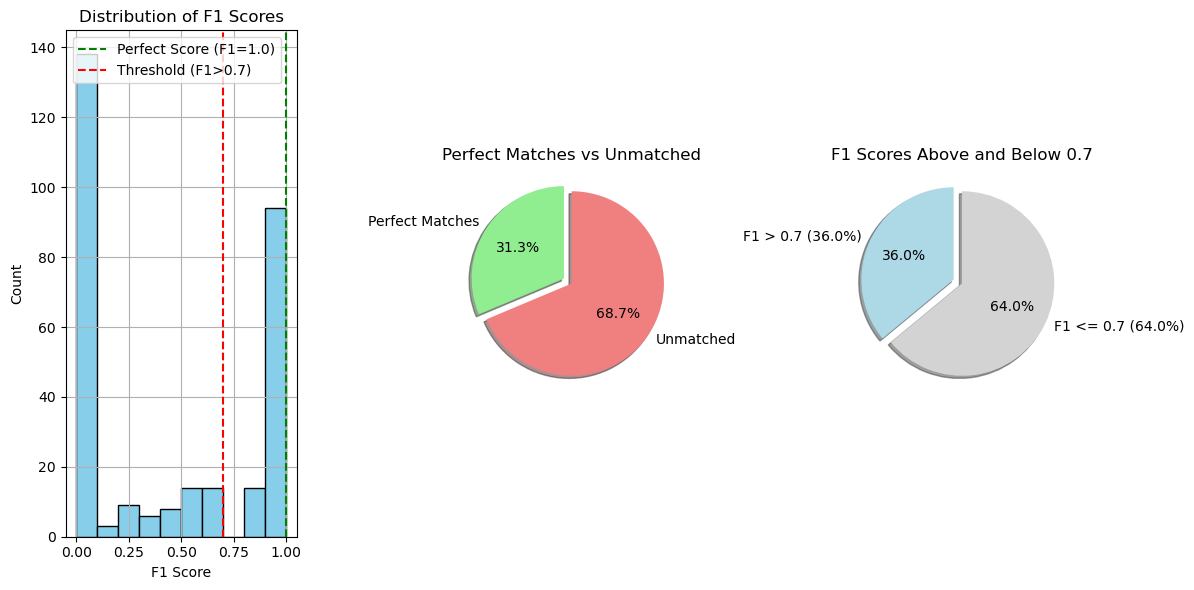

In [16]:
import matplotlib.pyplot as plt
import numpy as np

f1_scores = [item['f1'] for item in matched + unmatched]

threshold = 0.7 

above_threshold = [score for score in f1_scores if score > threshold]
below_threshold = [score for score in f1_scores if score <= threshold]

total_scores = len(f1_scores)
above_percentage = len(above_threshold) / total_scores * 100
below_percentage = len(below_threshold) / total_scores * 100

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(f1_scores, bins=np.arange(0, 1.1, 0.1), color='skyblue', edgecolor='black')
plt.axvline(x=1.0, color='green', linestyle='--', label='Perfect Score (F1=1.0)')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold (F1>{threshold})')
plt.title('Distribution of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Count')
plt.legend()
plt.grid()

labels = ['Perfect Matches', 'Unmatched']
sizes = [len(matched), len(unmatched)]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  

plt.subplot(1, 3, 2)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Perfect Matches vs Unmatched')

labels_threshold = [f'F1 > {threshold} ({above_percentage:.1f}%)', f'F1 <= {threshold} ({below_percentage:.1f}%)']
sizes_threshold = [len(above_threshold), len(below_threshold)]
colors_threshold = ['lightblue', 'lightgray']
explode_threshold = (0.1, 0)

plt.subplot(1, 3, 3)
plt.pie(sizes_threshold, explode=explode_threshold, labels=labels_threshold, colors=colors_threshold, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title(f'F1 Scores Above and Below {threshold}')

plt.tight_layout()
plt.show()
